In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Zindi_VehicleInsuranceClaim/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/Zindi_VehicleInsuranceClaim/Test.csv')
ss = pd.read_csv('/content/drive/MyDrive/Zindi_VehicleInsuranceClaim/SampleSubmission.csv')

In [ ]:
train['is_train'] = 1
test['is_train'] = 0

In [ ]:
ntrain = train.shape[0] # to be used to split train and test set from the all_data dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the all_data dataframe is: {all_data.shape}')

The shape of the all_data dataframe is: (13281, 15)


In [ ]:
all_data.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,is_train
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0.0,1
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1.0,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0.0,1
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0.0,1
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1.0,1


In [ ]:
# state_names = pd.read_csv('/content/drive/MyDrive/Zindi_VehicleInsuranceClaim/NigerianStateNames.csv')
# state_names.drop_duplicates(subset=['LGA'],keep="first",inplace=True)
# all_data = pd.merge(all_data.drop("State",axis=1), state_names[['LGA','State']], left_on=['LGA_Name'],
#          right_on=["LGA"], how="left")
# all_data.drop("LGA",axis=1,inplace=True)

In [ ]:
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target','is_train']]

for col in all_data.columns:
  if col in date_cols:
    all_data[col] = pd.to_datetime(all_data[col])
  elif col in cat_cols:
    all_data[col] = all_data[col].astype('category')

# Confirm whether the changes have been applied successfully
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      13281 non-null  object        
 1   Policy Start Date       13281 non-null  datetime64[ns]
 2   Policy End Date         13281 non-null  datetime64[ns]
 3   Gender                  12881 non-null  category      
 4   Age                     13281 non-null  int64         
 5   First Transaction Date  13281 non-null  datetime64[ns]
 6   No_Pol                  13281 non-null  int64         
 7   Car_Category            9171 non-null   category      
 8   Subject_Car_Colour      5622 non-null   category      
 9   Subject_Car_Make        10557 non-null  category      
 10  LGA_Name                6149 non-null   category      
 11  State                   6137 non-null   category      
 12  ProductName             13281 non-null  catego

In [ ]:
all_data['Gender'].fillna("NOT STATED",inplace=True)

In [ ]:
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
all_data.Gender = all_data.Gender.replace(mapper)

# Confirm mappings
all_data.Gender.value_counts()

Male      8356
Female    3679
Other     1246
Name: Gender, dtype: int64

In [ ]:
# Lets fill na for Car Category and Car Make 
# Car Category using ProductName and CarMake using Car Category


## Car Category null value imputation

In [ ]:
# sample_df = all_data.copy()
# sample_df['Car_Count'] = sample_df['Car_Category']
# sample_df = sample_df.groupby(['ProductName','Car_Category'],as_index=False)['Car_Count'].count()
# sample_df = sample_df[~sample_df['Car_Count'].isnull()]
# sample_df.sort_values(by=['ProductName','Car_Count'], ascending=False,inplace=True)

In [ ]:
# tmp = sample_df.groupby("ProductName",as_index=False).max()
# sample_df = pd.merge(tmp[['ProductName',"Car_Count"]],sample_df[['ProductName','Car_Category','Car_Count']], on=['ProductName','Car_Count'],how="inner")
# sample_df.drop("Car_Count",axis=1,inplace=True)

In [ ]:
# sample_df.columns = ["ProductName",'Category_Car']
# all_data = pd.merge(all_data, sample_df[['ProductName','Category_Car']], on="ProductName")
# all_data['Car_Category'] = np.where(all_data['Car_Category'].isnull(), all_data['Category_Car'],all_data['Car_Category'])
# all_data.drop("Category_Car",axis=1,inplace=True)
# del sample_df
# del tmp

In [ ]:
# all_data.isnull().sum()

## Null value imputation for Car Make

In [ ]:
# sample_df = all_data.copy()
# sample_df['Car_Make'] = all_data['Subject_Car_Make']

In [ ]:
# sample_df = sample_df.groupby(['Car_Category','Subject_Car_Make'],as_index=False)['Car_Make'].count()

In [ ]:
# sample_df.head()

In [ ]:
# sample_df = sample_df[~sample_df['Car_Make'].isnull()]
# sample_df.sort_values(by=['Car_Category','Car_Make'], ascending=False,inplace=True)

In [ ]:
# tmp = sample_df.groupby("Car_Category",as_index=False).max()
# sample_df = pd.merge(tmp[['Car_Category',"Car_Make"]],sample_df[['Car_Category','Subject_Car_Make','Car_Make']], on=['Car_Category','Car_Make'],how="inner")
# sample_df.drop("Car_Make",axis=1,inplace=True)

In [ ]:
# sample_df.columns = ["Car_Category",'Car_Make_subject']
# all_data = pd.merge(all_data, sample_df[['Car_Category','Car_Make_subject']], on="Car_Category")
# all_data['Subject_Car_Make'] = np.where(all_data['Subject_Car_Make'].isnull(), all_data['Car_Make_subject'],all_data['Subject_Car_Make'])
# all_data.drop("Car_Make_subject",axis=1,inplace=True)
# del sample_df
# del tmp

In [ ]:
# all_data.isnull().sum()

# Age values

In [ ]:
all_data['Age'].describe()

count    13281.000000
mean        42.375574
std         93.170951
min      -6099.000000
25%         35.000000
50%         41.000000
75%         50.000000
max        320.000000
Name: Age, dtype: float64

In [ ]:
#For Nigeria (West Africa), the minimum age for license is 18
all_data['Age'] = np.where(all_data['Age'] < 18, 18, all_data['Age'])

In [ ]:
# The minimum age requirement for a driver is 18 and the maximum age allowed is 70. for Nigeria
all_data['Age'] = np.where(all_data['Age'] > 70, 70, all_data['Age'])

In [ ]:
all_data["Age"].describe()

count    13281.000000
mean        42.432121
std         12.911454
min         18.000000
25%         35.000000
50%         41.000000
75%         50.000000
max         70.000000
Name: Age, dtype: float64

In [ ]:
high_risk_drivers = (((all_data['Age'] >= 18) & (all_data['Age'] <= 30)) | (all_data['Age'] > 60))
medium_risk_drivers = ((all_data['Age'] > 30) & (all_data['Age'] < 45))
low_risk_drivers = ((all_data['Age'] >= 45) & (all_data['Age'] <= 60))
all_data.loc[:,'risk_by_age'] = "None"
all_data['risk_by_age'] = np.where(high_risk_drivers,'high risk', all_data['risk_by_age'])
all_data['risk_by_age'] = np.where(medium_risk_drivers, 'medium risk', all_data['risk_by_age'])
all_data['risk_by_age'] = np.where(low_risk_drivers, 'low risk', all_data['risk_by_age'])

all_data['risk_by_age'] = all_data['risk_by_age'].astype('category')

In [ ]:
# from scipy import stats
# all_data['Age'], _ = stats.boxcox(np.array(all_data['Age']))

In [ ]:
# sns.kdeplot(all_data['Age'])

In [ ]:
all_data['Age'] = np.log(all_data['Age'])

In [ ]:
# Date Based Features

for col in date_cols:
  for date_feature in ['year', 'month', 'day','Dayofweek', 'Dayofyear']:
    all_data[col+date_feature+'1'] = getattr(all_data[col].dt, date_feature.lower())
    all_data[col+date_feature] = np.sin(getattr(all_data[col].dt, date_feature.lower()))

In [ ]:
# based on feature importance drop these features (redundant)
all_data.drop(['Policy Start DateDayofweek', 'Policy Start DateDayofyear',
       'Policy Start Dateday', 'Policy Start Datemonth',
       'Policy Start Dateyear'], axis=1, inplace=True)

In [ ]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# all_data['Age'] = sc.fit_transform(np.array(all_data['Age']).reshape((-1,1)))

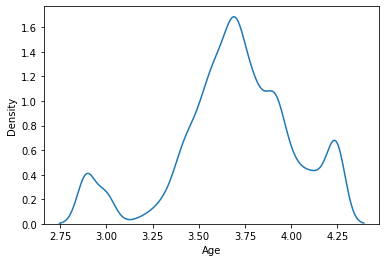

In [ ]:
sns.kdeplot(all_data['Age'])

In [ ]:
cat_cols.append("risk_by_age")

# Other FILLNA

In [ ]:
cat_cols

['Gender',
 'Car_Category',
 'Subject_Car_Colour',
 'Subject_Car_Make',
 'LGA_Name',
 'State',
 'ProductName',
 'risk_by_age']

In [ ]:
for col in all_data.columns:
  if col in date_cols+cat_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
  elif col in num_cols:
    all_data[col] = all_data[col].fillna(all_data[col].fillna(9999))

# Confirm that there aren't any missing values
all_data[all_data.columns.difference(['target'])].isna().sum()

Age                                 0
Car_Category                        0
First Transaction Date              0
First Transaction DateDayofweek     0
First Transaction DateDayofweek1    0
First Transaction DateDayofyear     0
First Transaction DateDayofyear1    0
First Transaction Dateday           0
First Transaction Dateday1          0
First Transaction Datemonth         0
First Transaction Datemonth1        0
First Transaction Dateyear          0
First Transaction Dateyear1         0
Gender                              0
ID                                  0
LGA_Name                            0
No_Pol                              0
Policy End Date                     0
Policy End DateDayofweek            0
Policy End DateDayofweek1           0
Policy End DateDayofyear            0
Policy End DateDayofyear1           0
Policy End Dateday                  0
Policy End Dateday1                 0
Policy End Datemonth                0
Policy End Datemonth1               0
Policy End D

In [ ]:
# all_data['Duration_of_policy(days)'] = (all_data['Policy End Date'] - all_data['Policy Start Date']).dt.days
# # sc = StandardScaler()
# # all_data['Duration_of_policy(days)'] = sc.fit_transform(np.array(all_data['Duration_of_policy(days)']).reshape((-1,1)))

In [ ]:
all_data['Gender_Age'] = np.log(all_data.groupby(['Gender'])['Age'].transform('std'))
all_data['Gender_Age2'] = np.log(all_data.groupby(['Gender'])['Age'].transform('max'))
all_data['Gender_Age3'] = np.log(all_data.groupby(['Gender'])['Age'].transform('mean'))

all_data['Gender_Policy'] = np.log(all_data.groupby(['Gender'])['No_Pol'].transform('max'))
all_data['Gender_Policy1'] = np.log(all_data.groupby(['Gender'])['No_Pol'].transform('sum'))
all_data['Gender_Policy2'] = np.log(all_data.groupby(['Gender'])['No_Pol'].transform('mean'))

# all_data['Gender_duration'] = all_data.groupby(['Gender'])['Duration_of_policy(days)'].transform('max')
# all_data['Gender_duration1'] = all_data.groupby(['Gender'])['Duration_of_policy(days)'].transform('std')
# all_data['Gender_duration2'] = all_data.groupby(['Gender'])['Duration_of_policy(days)'].transform('mean')

# all_data['Car_Category_Age'] = np.log(all_data.groupby(['Car_Category'])['Age'].transform('std'))
all_data['Car_Category_Age2'] = np.log(all_data.groupby(['Car_Category'])['Age'].transform('max'))
all_data['Car_Category_Age3'] = np.log(all_data.groupby(['Car_Category'])['Age'].transform('mean'))

all_data['Car_Category_Policy'] = np.log(all_data.groupby(['Car_Category'])['No_Pol'].transform('max'))
all_data['Car_Category_Policy1'] = np.log(all_data.groupby(['Car_Category'])['No_Pol'].transform('sum'))
all_data['Car_Category_Policy2'] = np.log(all_data.groupby(['Car_Category'])['No_Pol'].transform('mean'))

# all_data['Car_Category_duration'] = all_data.groupby(['Car_Category'])['Duration_of_policy(days)'].transform('max')
# # all_data['Car_Category_duration1'] = all_data.groupby(['Car_Category'])['Duration_of_policy(days)'].transform('std')
# all_data['Car_Category_duration2'] = all_data.groupby(['Car_Category'])['Duration_of_policy(days)'].transform('mean')

# all_data['Subject_Car_Make_Age'] = np.log(all_data.groupby(['Subject_Car_Make'])['Age'].transform('std'))
all_data['Subject_Car_Make_Age2'] = np.log(all_data.groupby(['Subject_Car_Make'])['Age'].transform('max'))
all_data['Subject_Car_Make_Age3'] = np.log(all_data.groupby(['Subject_Car_Make'])['Age'].transform('mean'))

all_data['Subject_Car_Make_Policy'] = np.log(all_data.groupby(['Subject_Car_Make'])['No_Pol'].transform('max'))
all_data['Subject_Car_Make_Policy1'] = np.log(all_data.groupby(['Subject_Car_Make'])['No_Pol'].transform('sum'))
all_data['Subject_Car_Make_Policy2'] = np.log(all_data.groupby(['Subject_Car_Make'])['No_Pol'].transform('mean'))

# all_data['Subject_Car_Make_duration'] = all_data.groupby(['Subject_Car_Make'])['Duration_of_policy(days)'].transform('max')
# # all_data['Subject_Car_Make_duration1'] = all_data.groupby(['Subject_Car_Make'])['Duration_of_policy(days)'].transform('std')
# all_data['Subject_Car_Make_duration2'] = all_data.groupby(['Subject_Car_Make'])['Duration_of_policy(days)'].transform('mean')

all_data['ProductName_Age'] = np.log(all_data.groupby(['ProductName'])['Age'].transform('std'))
all_data['ProductName_Age2'] = np.log(all_data.groupby(['ProductName'])['Age'].transform('max'))
all_data['ProductName_Age3'] = np.log(all_data.groupby(['ProductName'])['Age'].transform('mean'))

all_data['ProductName_Car_Category'] = np.log(all_data.groupby(['ProductName'])['Car_Category'].transform('count'))
all_data['ProductName_Car_Make'] = np.log(all_data.groupby(['ProductName'])['Subject_Car_Make'].transform('count'))

all_data['ProductName_Policy'] = np.log(all_data.groupby(['ProductName'])['No_Pol'].transform('max'))
all_data['ProductName_Policy1'] = np.log(all_data.groupby(['ProductName'])['No_Pol'].transform('sum'))
all_data['ProductName_Policy2'] = np.log(all_data.groupby(['ProductName'])['No_Pol'].transform('mean'))

# all_data['ProductName_duration'] = all_data.groupby(['ProductName'])['Duration_of_policy(days)'].transform('max')
# all_data['ProductName_duration1'] = all_data.groupby(['ProductName'])['Duration_of_policy(days)'].transform('std')
# all_data['ProductName_duration2'] = all_data.groupby(['ProductName'])['Duration_of_policy(days)'].transform('mean')

# all_data['State_Age'] = np.log(all_data.groupby(['State'])['Age'].transform('std'))
all_data['State_Age2'] = np.log(all_data.groupby(['State'])['Age'].transform('max'))
all_data['State_Age3'] = np.log(all_data.groupby(['State'])['Age'].transform('mean'))

all_data['State_Car_Category'] = np.log(all_data.groupby(['State'])['Car_Category'].transform('count'))
all_data['State_Car_Make'] = np.log(all_data.groupby(['State'])['Subject_Car_Make'].transform('count'))

all_data['State_Policy'] = np.log(all_data.groupby(['State'])['No_Pol'].transform('max'))
all_data['State_Policy1'] = np.log(all_data.groupby(['State'])['No_Pol'].transform('sum'))
all_data['State_Policy2'] = np.log(all_data.groupby(['State'])['No_Pol'].transform('mean'))

# all_data['State_duration'] = all_data.groupby(['State'])['Duration_of_policy(days)'].transform('max')
# # all_data['State_duration1'] = all_data.groupby(['State'])['Duration_of_policy(days)'].transform('std')
# all_data['State_duration2'] = all_data.groupby(['State'])['Duration_of_policy(days)'].transform('mean')

In [ ]:
# all_data['FE_GENDER_CAR_CATEGORY_AGE1'] = all_data.groupby(['Car_Category',\
#                                                 'Gender'])['Age'].transform('count')
# all_data['FE_GENDER_CAR_CATEGORY_AGE2'] = all_data.groupby(['Car_Category',\
#                                                 'Gender'])['Age'].transform('sum')
# all_data['FE_GENDER_CAR_CATEGORY_AGE3'] = all_data.groupby(['Car_Category',\
#                                                 'Gender'])['Age'].transform('mean')
# # all_data['FE_GENDER_CAR_CATEGORY_AGE4'] = all_data.groupby(['Car_Category',\
# #                                                 'Gender'])['Age'].transform('std')
# # all_data['FE_GENDER_CAR_CATEGORY_AGE5'] = all_data.groupby(['Car_Category',\
# #                                                 'Gender'])['Age'].transform('skew')
# all_data['FE_GENDER_CAR_CATEGORY_AGE6'] = all_data.groupby(['Car_Category',\
#                                                 'Gender'])['Age'].transform('max')

# all_data['FE_GENDER_CAR_CATEGORY_No_Pol1'] = all_data.groupby(['Car_Category',\
#                                                    'Gender'])['No_Pol'].transform('count')
# all_data['FE_GENDER_CAR_CATEGORY_No_Pol2'] = all_data.groupby(['Car_Category',\
#                                                    'Gender'])['No_Pol'].transform('sum')
# all_data['FE_GENDER_CAR_CATEGORY_No_Pol3'] = all_data.groupby(['Car_Category',\
#                                                    'Gender'])['No_Pol'].transform('mean')
# # all_data['FE_GENDER_CAR_CATEGORY_No_Pol4'] = all_data.groupby(['Car_Category',\
# #                                                    'Gender'])['No_Pol'].transform('std')
# # all_data['FE_GENDER_CAR_CATEGORY_No_Pol5'] = all_data.groupby(['Car_Category',\
# #                                                    'Gender'])['No_Pol'].transform('skew')
# all_data['FE_GENDER_CAR_CATEGORY_No_Pol6'] = all_data.groupby(['Car_Category',\
#                                                    'Gender'])['No_Pol'].transform('max')

In [ ]:
# all_data['FE_GENDER_CC_PN_AGE1'] = all_data.groupby(['Car_Category',\
#                                                 'ProductName',\
#                                                 'Gender'])['Age'].transform('count')
# all_data['FE_GENDER_CC_PN_AGE2'] = all_data.groupby(['Car_Category',\
#                                                 'ProductName',\
#                                                 'Gender'])['Age'].transform('sum')
# all_data['FE_GENDER_CC_PN_AGE3'] = all_data.groupby(['Car_Category',\
#                                                 'ProductName',\
#                                                 'Gender'])['Age'].transform('mean')
# # all_data['FE_GENDER_CC_PN_AGE4'] = all_data.groupby(['Car_Category',\
# #                                                 'ProductName',\
# #                                                 'Gender'])['Age'].transform('std')
# # all_data['FE_GENDER_CC_PN_AGE5'] = all_data.groupby(['Car_Category',\
# #                                                 'ProductName',\
# #                                                 'Gender'])['Age'].transform('skew')
# all_data['FE_GENDER_CC_PN_AGE6'] = all_data.groupby(['Car_Category',\
#                                                 'ProductName',\
#                                                 'Gender'])['Age'].transform('max')

# all_data['FE_GENDER_CC_PN_NO_POL1'] = all_data.groupby(['Car_Category',\
#                                                    'ProductName',\
#                                                    'Gender'])['No_Pol'].transform('count')
# all_data['FE_GENDER_CC_PN_NO_POL2'] = all_data.groupby(['Car_Category',\
#                                                    'ProductName',\
#                                                    'Gender'])['No_Pol'].transform('sum')
# all_data['FE_GENDER_CC_PN_NO_POL3'] = all_data.groupby(['Car_Category',\
#                                                    'ProductName',\
#                                                    'Gender'])['No_Pol'].transform('mean')
# # all_data['FE_GENDER_CC_PN_NO_POL4'] = all_data.groupby(['Car_Category',\
# #                                                    'ProductName',\
# #                                                    'Gender'])['No_Pol'].transform('std')
# # all_data['FE_GENDER_CC_PN_NO_POL5'] = all_data.groupby(['Car_Category',\
# #                                                    'ProductName',\
# #                                                    'Gender'])['No_Pol'].transform('skew')
# all_data['FE_GENDER_CC_PN_NO_POL6'] = all_data.groupby(['Car_Category',\
#                                                    'ProductName',\
#                                                    'Gender'])['No_Pol'].transform('max')

In [ ]:
s = pd.DataFrame(all_data.isnull().sum(), columns=['ss'])
s['ss'].value_counts()

0       71
1202     1
Name: ss, dtype: int64

In [ ]:
s[s['ss'] > 0]

,ss
target,1202


# FE

In [ ]:
# all_data.loc[:,'Policy_no_cat'] = "Multiple Polcies"
# all_data['Policy_no_cat'] = np.where(all_data['No_Pol'] == 1, "Single Policy", all_data['Policy_no_cat'])
# all_data['Policy_no_cat'] = np.where(all_data['No_Pol'] == 2, "Dual Policies", all_data['Policy_no_cat'])

# cat_cols.append("Policy_no_cat")

# all_data.drop("No_Pol",axis=1,inplace=True)

In [ ]:
# def add_datepart(df, fldname, drop=True):
#     fld = df[fldname]
#     if not np.issubdtype(fld.dtype, np.datetime64):
#         df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
#     targ_pre = re.sub('[Dd]ate$', '', fldname)
#     for n in ('Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
#             'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
#         df[targ_pre+n] = getattr(fld.dt,n.lower())

#     if drop: df.drop(fldname, axis=1, inplace=True)
# import re
# add_datepart(all_data, 'Policy Start Date')
# add_datepart(all_data, 'Policy End Date')
# add_datepart(all_data, 'First Transaction Date')

In [ ]:
# import math

In [ ]:
# for col in date_cols:
#   for date_feature in ['year', 'month', 'day']:
#     all_data[col+date_feature] = getattr(all_data[col].dt, date_feature)
# # all_data = all_data.fillna(-999)
# all_data.head()

In [ ]:
# Encode categorical features
all_data = pd.get_dummies(data = all_data, columns = cat_cols)
all_data.head()

,ID,Policy Start Date,Policy End Date,Age,First Transaction Date,No_Pol,target,is_train,Policy Start Dateyear1,Policy Start Datemonth1,Policy Start Dateday1,Policy Start DateDayofweek1,Policy Start DateDayofyear1,Policy End Dateyear1,Policy End Dateyear,Policy End Datemonth1,Policy End Datemonth,Policy End Dateday1,Policy End Dateday,Policy End DateDayofweek1,Policy End DateDayofweek,Policy End DateDayofyear1,Policy End DateDayofyear,First Transaction Dateyear1,First Transaction Dateyear,First Transaction Datemonth1,First Transaction Datemonth,First Transaction Dateday1,First Transaction Dateday,First Transaction DateDayofweek1,First Transaction DateDayofweek,First Transaction DateDayofyear1,First Transaction DateDayofyear,Gender_Age,Gender_Age2,Gender_Age3,Gender_Policy,Gender_Policy1,Gender_Policy2,Car_Category_Age2,...,State_Ogba-Ndoni,State_Ogbmosho-South,State_Ogun,State_Ogun-Waterside,State_Ondo,State_Ondo-West,State_Onitsha-North,State_Onitsha-South,State_Orile-Iganmu,State_Oshimili-North,State_Oshodi-Isolo,State_Osun,State_Ovia-SouthWest,State_Owerri-Municipal,State_Owerri-North,State_Owerri-West,State_Oyo,State_Oyo-East,State_Oyo-West,State_Port-Harcourt,State_QuaAn-Pan,State_Rivers,State_Udi-Agwu,State_Ughelli-North,State_Umuahia-South,State_Warri-Central,State_Warri-North,State_Warri-South,ProductName_CVTP,ProductName_Car Classic,ProductName_Car Plus,ProductName_Car Vintage,ProductName_CarFlex,ProductName_CarSafe,ProductName_Customized Motor,ProductName_Motor Cycle,ProductName_Muuve,risk_by_age_high risk,risk_by_age_low risk,risk_by_age_medium risk
0,ID_0040R73,2010-05-14,2011-05-13,3.401197,2010-05-14,1,0.0,1,2010,5,14,4,134,2011,0.371572,5,-0.958924,13,0.420167,4,-0.756802,133,0.868966,2010,-0.580464,5,-0.958924,14,0.990607,4,-0.756802,134,0.885925,-1.213830,1.446565,1.311375,1.791759,9.269458,0.238723,1.446565,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,ID_0046BNK,2010-11-29,2011-11-28,4.248495,2010-11-29,1,1.0,1,2010,11,29,0,333,2011,0.371572,11,-0.999990,28,0.270906,0,0.000000,332,-0.846204,2010,-0.580464,11,-0.999990,29,-0.663634,0,0.000000,333,-0.008821,-1.189155,1.446565,1.306964,1.791759,8.424859,0.214462,1.446565,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,ID_005QMC3,2010-03-21,2011-03-20,3.761200,2010-03-21,1,0.0,1,2010,3,21,6,80,2011,0.371572,3,0.141120,20,0.912945,6,-0.279415,79,-0.444113,2010,-0.580464,3,0.141120,21,0.836656,6,-0.279415,80,-0.993889,-1.213830,1.446565,1.311375,1.791759,9.269458,0.238723,1.446565,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,ID_0079OHW,2010-08-21,2011-08-20,2.890372,2010-08-21,1,0.0,1,2010,8,21,5,233,2011,0.371572,8,0.989358,20,0.912945,5,-0.958924,232,-0.459877,2010,-0.580464,8,0.989358,21,0.836656,5,-0.958924,233,0.498739,-1.213830,1.446565,1.311375,1.791759,9.269458,0.238723,1.446565,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,ID_00BRP63,2010-08-29,2010-12-31,2.995732,2010-08-29,3,1.0,1,2010,8,29,6,241,2010,-0.580464,12,-0.536573,31,-0.404038,4,-0.756802,365,0.544046,2010,-0.580464,8,0.989358,29,-0.663634,6,-0.279415,241,0.784962,-0.703459,1.446565,1.287461,2.302585,7.665753,0.538060,1.446565,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [ ]:
# cluster = all_data.copy().fillna(0)
# cluster.drop(['ID','is_train','target','Policy Start Date','Policy End Date','First Transaction Date'], axis=1, inplace=True)  # removing LGA_Name and subject Car colour
# from sklearn.cluster import KMeans
# kmeanModel = KMeans(n_clusters=7)
# preds = kmeanModel.fit_predict(cluster)
# all_data['customer_seg'] = preds

In [ ]:
# all_data.drop("customer_seg",axis=1,inplace=True)

In [ ]:
main_cols = all_data.columns.difference(date_cols+['ID', 'target','is_train'])

In [ ]:
train_df = all_data[all_data['is_train'] == 1]
test_df = all_data[all_data['is_train'] == 0]

In [ ]:
# train_df = all_data[:ntrain]
# test_df = all_data[ntrain:]

# # Check the shapes of the split dataset
# train_df.shape, test_df.shape

In [ ]:
train_df.drop("is_train",axis=1,inplace=True)
test_df.drop("is_train",axis=1,inplace=True)

# Oversampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, RandomOverSampler, SMOTE

In [ ]:
cat = CatBoostClassifier(iterations=220,od_type="Iter",l2_leaf_reg=5,
                           learning_rate=0.95,verbose=0,
                           depth=10) 

In [ ]:
# !pip install PyImpetus

In [ ]:
X = train_df[main_cols].values
y = train_df.target

us = RandomUnderSampler(0.2)  # 0.2
os = RandomOverSampler(0.95, random_state=10)   #0.95
print(X.shape, y.shape)
X, y = os.fit_resample(X, y)
print(X.shape, y.shape)

(12079, 593) (12079,)
(20716, 593) (20716,)


In [ ]:
cat.fit(X,y)

In [ ]:
feature_index = np.where(cat.feature_importances_ > 0)[0]

In [ ]:
X.shape

(20716, 593)

In [ ]:
len(feature_index)

286

In [ ]:
X = X[:, feature_index]

# Voting Classifier

In [ ]:
#F1 score on the X_test is: 0.9492 highest
# F1 score 0.94959 - 0.4
# F1 score 0.94977 (if date part added) - lower score
# F1 score 0.9473 (when segmenting customers)
# 0.9498


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as xg
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# Train model
model1 = CatBoostClassifier(iterations=220,od_type="Iter",l2_leaf_reg=5,
                           learning_rate=0.95,verbose=0,
                           depth=10)  # iteration 220

model5= LGBMClassifier(learning_rate=0.5,n_estimators=1000,num_leaves=120,n_jobs =4,min_child_samples= 14,
 min_child_weight= 10)

xgb = xg.XGBClassifier(n_estimators=1000,
                      max_depth=6,
                      learning_rate=0.04,
                      subsample=0.9,
                      colsample_bytree=0.35,
                       objective = 'binary:logistic',
                       random_state = 1)

model = VotingClassifier(estimators=[('cat', model1),('lgbm',model5)], voting='hard')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
#y_pred_tab = model6.predict(X_test)
# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')


F1 score on the X_test is: 0.9499447339333649


In [ ]:
model.fit(X, y)  ## full dataset

VotingClassifier(estimators=[('cat',
                              <catboost.core.CatBoostClassifier object at 0x7f08e542cd90>),
                             ('lgbm',
                              LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.5, max_depth=-1,
                                             min_child_samples=14,
                                             min_child_weight=10,
                                             min_split_gain=0.0,
                                             n_estimators=1000, n_jobs=4,
                                             num_leaves=120, objective=None,
                                             random_state=None, reg_alpha=0.0,
                                             reg_lambda=0.0

In [ ]:
#F1 score on the X_test is: 0.9694170117871934
#F1 score on the X_test is: 0.9694170117871934 

In [ ]:
y_pred = model.predict(X_test)
#y_pred_tab = model6.predict(X_test)
# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')

F1 score on the X_test is: 0.9694170117871934


# Kfold

In [ ]:
# from sklearn.model_selection import StratifiedKFold
# train_df['kfold'] = -1

# kf = StratifiedKFold(n_splits=5)

# for f, (train_idx, valid_idx) in enumerate(kf.split(X = train_df, y = train_df['target'].values)):
#   train_df.loc[valid_idx,'kfold'] = f

In [ ]:
# def build_model(train_df):

# Prediction with submission file

In [ ]:
test_df = test_df[main_cols].values
print(test_df.shape)
test_df = test_df[:, feature_index]
print(test_df.shape)

(1202, 593)
(1202, 286)


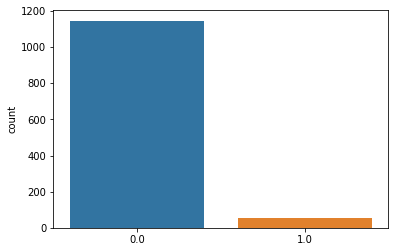

In [ ]:
# Make prediction on the test set
# test_df = test_df[main_cols]
predictions = model.predict(test_df)

# Create a submission file
sub_file = ss.copy()
sub_file.predictions = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.predictions);

In [ ]:
ss["target"] = predictions.astype("int")

In [ ]:
ss['target'].value_counts()

0    1146
1      56
Name: target, dtype: int64

In [ ]:
ss.to_csv("submission_feature_selection_v3.csv",index=False)

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/no_features__4_.csv")


In [ ]:
df['target'].value_counts()

0    1111
1      91
Name: target, dtype: int64

In [ ]:
df_new = pd.DataFrame(columns=['sub1','sub2','sub3'])
df_new['sub1'] = df['target']
df_new['sub2'] = df1['target']
df_new['sub3'] = df2['target']

In [ ]:
df_new['target'] = df_new[['sub1','sub2','sub3']].mode(axis=1)[0]

In [ ]:
df_new['target'].value_counts()

0    1138
1      64
Name: target, dtype: int64

In [ ]:
df['target'].value_counts()

0    1111
1      91
Name: target, dtype: int64

In [ ]:
df['target'] = df_new['target']

In [ ]:
df['target'].value_counts()

0    1138
1      64
Name: target, dtype: int64

In [ ]:
df.to_csv("3_outputs.csv",index=False)